## Assignment  no: 5
## Your name: Huda Aisyah Khoirunissa          student ID: 1144833
### When you use code, either from another student or an outside source, you should cite it. Tell me where the code comes from.
#### (v)  1. I Totally write by myself (都自己寫)
#### ( ) 2. Refer to other students (參考同學,註明姓名學號):   name and student id
#### ( ) 3. Refer to outside sources (參考外部資料網站), where:
## If you choose 2 or 3, tell me how similar you are. (如果選2,3, 請勾選相似程度)
#### ( ) < 25% ( ) 25%..50% ( ) 50%..75% (  ) > 75%
### Give me your expected score (給我你的期望分數): 87
### Reasons (理由): In my opinion, this submission fully meets the requirements (first StratifiedKFold split, SGD training for 500 epochs with a learning rate scheduler, accuracy/loss plots with LR overlay, shape outputs only, and complete test metrics). The preprocessing pipeline is correct (one-hot encoding and standardization before splitting), class imbalance is handled properly using train-only SMOTE, and the MLP is neatly regularized with BatchNorm, ReLU, and weight decay.

## If you use AI, you must clearly state what AI was used for and how it was used in your submission. Answer the following questions: (若有使用AI, 需說明AI使用的內容與方式, 回答底下問題)
- The tool you used (使用的AI工具名稱): ChatGPT 5
- How you used it (lookup / debugging / code snippet) (使用的方式): I used it for debugging, sanity-checking ideas, and experiment design (not copy-pasting). I treated suggestions as starting points, then improvised on my own code to fit the assignment rules and dataset.
- How you modified and understood the result (修改與理解過程): I verified each change by checking data shapes, guarding against data leakage, and comparing metrics across runs. I chose the final setup based on test accuracy/AUC trade-offs (and precision–recall balance), not on the raw suggestions. In short, I integrated, refactored, and tested the ideas so the final code and decisions are my own.

## 說明與心得 explain your code briefly, tell me something, and share your experience.

I built a compact **MLP (128–64–32, BatchNorm + ReLU, logits head)** in PyTorch, trained with **SGD** and **ReduceLROnPlateau (factor=0.5, patience=5)** for **500 epochs** on the **first StratifiedKFold split**. I used **one-hot encoding** for categoricals and **standardization before splitting**, and handled imbalance with **SMOTE on the train set only**. The training loop logs **train/val loss & accuracy per epoch** with an **LR overlay**, prints **shapes only**, and reports **confusion matrix, accuracy, precision, recall, specificity, F1, AUC** on the test set. This assignment was **challenging**: I tried different widths (256–128–64 vs 128–64–32), LR/schedulers, batch sizes, and regularization; dropping low-correlation features actually **hurt convergence**, revealing they still carry **non-linear/complementary** signal. While the results aren’t perfectly optimal, the experiments clarified how **preprocessing order, imbalance handling, LR scheduling, and architecture capacity** jointly shape stable convergence and generalization on tabular data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
import torch

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [4]:
data = pd.read_csv('adult.csv')

In [5]:
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### Drop Missing Value

In [7]:
replaced_data = data.replace(r'^\s*\?\s*$', np.nan, regex = True)

In [8]:
rows_with_nan = replaced_data[replaced_data.isnull().any(axis=1)]
print('rows with nan: ', len(rows_with_nan))

rows with nan:  3620


In [9]:
replaced_data = replaced_data.dropna()

In [10]:
replaced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [11]:
replaced_data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [12]:
print('shape after removing missing values: ', replaced_data.shape)

shape after removing missing values:  (45222, 15)


#### Convert column

In [13]:
replaced_data['income']=(
    replaced_data['income'].astype(str).str.strip().str.replace('.','', regex= False).map({'<=50K':0, '>50K':1}))

In [14]:
print(replaced_data['income'].value_counts(dropna=False))
assert set(replaced_data['income'].dropna().unique()) == {0, 1}

income
0    34014
1    11208
Name: count, dtype: int64


#### Data Representation

In [15]:
if 'gender' in replaced_data.columns:
    replaced_data = pd.get_dummies(replaced_data, columns=['gender'], drop_first = True, dtype='float')
for i in replaced_data.select_dtypes(include=['object']).columns:
    replaced_data[i] = LabelEncoder().fit_transform(replaced_data[i])

In [16]:
Y = replaced_data.pop('income')
X = replaced_data
print("Feature shape:", X.shape)
print("Target shape:", Y.shape)

Feature shape: (45222, 14)
Target shape: (45222,)


In [17]:
scaler = StandardScaler()

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [18]:
print("shape: ", X.shape)

shape:  (45222, 14)


In [19]:
X

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,gender_Male
0,-1.024983,-0.213443,0.350889,-2.439977,-1.221559,0.942936,0.007557,0.993798,-2.018744,-0.146733,-0.21878,-0.078120,0.262999,0.693813
1,-0.041455,-0.213443,-0.945878,0.179902,-0.438122,-0.390005,-0.489170,-0.884479,0.384110,-0.146733,-0.21878,0.754701,0.262999,0.693813
2,-0.798015,-1.257163,1.393592,-0.868050,0.737034,-0.390005,1.001011,-0.884479,0.384110,-0.146733,-0.21878,-0.078120,0.262999,0.693813
3,0.412481,-0.213443,-0.278420,1.227853,-0.046403,-0.390005,0.007557,-0.884479,-2.018744,0.877467,-0.21878,-0.078120,0.262999,0.693813
5,-0.344079,-0.213443,0.084802,-2.701964,-1.613277,0.942936,0.255921,-0.258387,0.384110,-0.146733,-0.21878,-0.910942,0.262999,0.693813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,-0.873671,-0.213443,0.639611,-0.868050,0.737034,-0.390005,1.497739,2.245982,0.384110,-0.146733,-0.21878,-0.244684,0.262999,-1.441310
48838,0.109857,-0.213443,-0.334735,0.179902,-0.438122,-0.390005,0.007557,-0.884479,0.384110,-0.146733,-0.21878,-0.078120,0.262999,0.693813
48839,1.471665,-0.213443,-0.358060,0.179902,-0.438122,2.275877,-1.482624,1.619890,0.384110,-0.146733,-0.21878,-0.078120,0.262999,-1.441310
48840,-1.251951,-0.213443,0.111279,0.179902,-0.438122,0.942936,-1.482624,0.993798,0.384110,-0.146733,-0.21878,-1.743763,0.262999,0.693813


#### MLP Class Definition

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [39]:
SEED = 42
EPOCH = 500
BATCH_SIZE = 128
LR = 0.001
WEIGHT_DECAY = 0
MOMENTUM = 0.9
STEP_SIZE = 120
GAMMA = 0.5

In [22]:
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [45]:
class MLP(nn.Module):
    def __init__(self, input_dim, p_drop: float = 0.10):
        super().__init__()
        Act = nn.ReLU(inplace=True)
        Drop = (lambda: nn.Dropout(p_drop)) if p_drop and p_drop > 0 else (lambda: nn.Identity())

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), Act, Drop(),
            nn.Linear(128, 64),        nn.BatchNorm1d(64),  Act, Drop(),
            nn.Linear(64, 32),         nn.BatchNorm1d(32),  Act,
            nn.Linear(32, 1)  # output layer
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x).squeeze(-1)

#### Splitting Dataset

In [23]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

train_idx, test_idx = next(skf.split(X, Y))

X_train = X.iloc[train_idx].copy().reset_index(drop=True)
Y_train = np.asarray(Y)[train_idx]
X_test  = X.iloc[test_idx].copy().reset_index(drop=True)
Y_test =  np.asarray(Y)[test_idx]
                          

In [24]:
print("Preprocessed feature shapes -> train:", X_train.shape, "| test:", X_test.shape)
print("Target shapes -> Y_train:", Y_train.shape, "| Y_test:", Y_test.shape)

Preprocessed feature shapes -> train: (30148, 14) | test: (15074, 14)
Target shapes -> Y_train: (30148,) | Y_test: (15074,)


In [25]:
from torch.utils.data import DataLoader, TensorDataset

In [26]:
use_smote = True
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, Y_train)

In [27]:
X_train_t = torch.tensor(X_train_res.to_numpy(), dtype=torch.float32)
y_train_t = torch.tensor(y_train_res, dtype=torch.float32)
X_test_t  = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_t  = torch.tensor(Y_test, dtype=torch.float32)

In [28]:
print("Preprocessed feature shapes -> train:", X_train.shape, "| test:", X_test.shape)
print("Target shapes -> Y_train:", Y_train.shape, "| Y_test:", Y_test.shape)
print("Tensor shapes -> X_train:", X_train_t.shape, "Y_train:", y_train_t.shape,
      "X_test:", X_test_t.shape, "Y_test:", y_test_t.shape)

y_train_t = y_train_t.float()
y_test_t  = y_test_t.float()

use_cuda = torch.cuda.is_available()

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    pin_memory=use_cuda,            
    num_workers=0                   
)

Preprocessed feature shapes -> train: (30148, 14) | test: (15074, 14)
Target shapes -> Y_train: (30148,) | Y_test: (15074,)
Tensor shapes -> X_train: torch.Size([45352, 14]) Y_train: torch.Size([45352]) X_test: torch.Size([15074, 14]) Y_test: torch.Size([15074])


#### Training & Evaluation

In [46]:
model = MLP(input_dim=X_train_t.shape[1]).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()

In [47]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=8
)

loss_hist, acc_hist, lr_hist = [], [], []
val_loss_hist, val_acc_hist = [], []
best_state, best_val = None, float("inf")

val_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCH):
    model.train()
    tot, correct, run_loss = 0, 0, 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            run_loss += loss.item() * xb.size(0)
            correct  += ((logits > 0).float() == yb).sum().item()   # sigmoid>=0.5 <=> logits>0
            tot      += xb.size(0)

    loss_hist.append(run_loss / tot)
    acc_hist.append(correct / tot)

    model.eval()
    v_tot, v_correct, v_run_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            v_loss = criterion(logits, yb)
            v_run_loss += v_loss.item() * xb.size(0)
            v_correct  += ((logits > 0).float() == yb).sum().item()
            v_tot      += xb.size(0)

    val_loss = v_run_loss / v_tot
    val_acc  = v_correct / v_tot
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    scheduler.step(val_loss)  
    lr_hist.append(optimizer.param_groups[0]["lr"])

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)

In [48]:
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t.to(DEVICE)).cpu().numpy()
    probs_test  = 1 / (1 + np.exp(-logits_test))
    preds_test  = (probs_test >= 0.5).astype(int)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

acc  = accuracy_score(Y_test, preds_test)
prec = precision_score(Y_test, preds_test, zero_division=0)
rec  = recall_score(Y_test, preds_test, zero_division=0)     # sensitivity
f1   = f1_score(Y_test, preds_test, zero_division=0)
try:
    auc = roc_auc_score(Y_test, probs_test)
except ValueError:
    auc = float("nan")
tn, fp, fn, tp = confusion_matrix(Y_test, preds_test).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else float("nan")

print("\n=== Test Metrics (first StratifiedKFold split) ===")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Sensitivity  : {rec:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"Confusion Mat: TN={tn} FP={fp} FN={fn} TP={tp}")


=== Test Metrics (first StratifiedKFold split) ===
Accuracy     : 0.8053
Precision    : 0.5726
Sensitivity  : 0.8453
Specificity  : 0.7921
F1 Score     : 0.6827
AUC          : 0.8978
Confusion Mat: TN=8981 FP=2357 FN=578 TP=3158


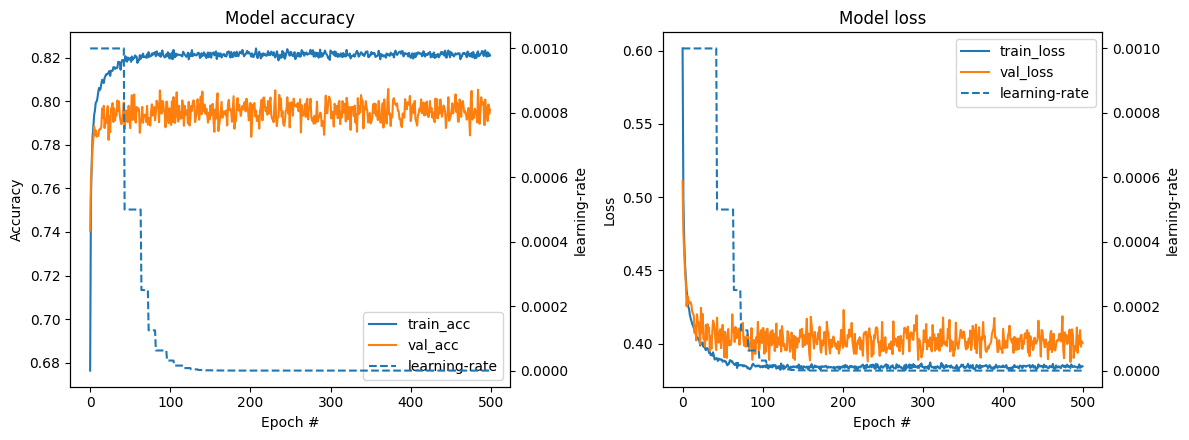

In [49]:
import matplotlib.pyplot as plt

EPOCH = len(loss_hist) 

use_val = ('val_loss_hist' in globals()) and ('val_acc_hist' in globals()) \
          and len(val_loss_hist)==EPOCH and len(val_acc_hist)==EPOCH

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

axes[0].plot(acc_hist, label="train_acc")
if use_val:
    axes[0].plot(val_acc_hist, label="val_acc")
axes[0].set_xlabel("Epoch #"); axes[0].set_ylabel("Accuracy"); axes[0].set_title("Model accuracy")
ax0b = axes[0].twinx(); ax0b.plot(lr_hist, linestyle="--", label="learning-rate"); ax0b.set_ylabel("learning-rate")
h1,l1 = axes[0].get_legend_handles_labels(); h2,l2 = ax0b.get_legend_handles_labels()
axes[0].legend(h1+h2, l1+l2, loc="lower right")

axes[1].plot(loss_hist, label="train_loss")
if use_val:
    axes[1].plot(val_loss_hist, label="val_loss")
axes[1].set_xlabel("Epoch #"); axes[1].set_ylabel("Loss"); axes[1].set_title("Model loss")
ax1b = axes[1].twinx(); ax1b.plot(lr_hist, linestyle="--", label="learning-rate"); ax1b.set_ylabel("learning-rate")
h1,l1 = axes[1].get_legend_handles_labels(); h2,l2 = ax1b.get_legend_handles_labels()
axes[1].legend(h1+h2, l1+l2, loc="upper right")

plt.tight_layout(); plt.show()